In [29]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator
import matplotlib.dates as mdates
import math
import datetime
from UniversalColor import UniversalColor
from SharedX import ShareXaxis
from legend_shadow import legend_shadow

import Leadangle_wave as Wave
from Leadangle_fit_JunoUVS import local_time_moon
from Leadangle_fit_JunoUVS import calc_eqlead
from Leadangle_fit_JunoUVS import Obsresults

import spiceypy as spice
spice.furnsh('kernel/cassMetaK.txt')
savpath = 'data/Satellite_FP_JRM33.sav'

UC = UniversalColor()
UC.set_palette()

In [30]:
def data_load(exname):
    chi2_1d = np.loadtxt('results/fit/'+exname+'/params_chi2.txt')
    Ai_1d = np.loadtxt('results/fit/'+exname+'/params_Ai.txt')
    ni_1d = np.loadtxt('results/fit/'+exname+'/params_ni.txt')
    Ti_1d = np.loadtxt('results/fit/'+exname+'/params_Ti.txt')
    H_1d = np.loadtxt('results/fit/'+exname+'/params_H.txt')
    et_obs = np.loadtxt('results/fit/'+exname+'/et_obs.txt')
    eqlead_obs = np.loadtxt('results/fit/'+exname+'/eqlead_obs.txt')
    eqlead_est = np.loadtxt('results/fit/'+exname+'/eqlead_est.txt')
    moon_s3wlon = np.loadtxt('results/fit/'+exname+'/moon_S3wlon_obs.txt')

    # Reshape the data
    chi2_3d = chi2_1d.reshape(ni_num, Ai_num, Ti_num)
    H_3d = H_1d.reshape(ni_num, Ai_num, Ti_num)
    Ai_3d = Ai_1d.reshape(ni_num, Ai_num, Ti_num)
    ni_3d = ni_1d.reshape(ni_num, Ai_num, Ti_num)
    Ti_3d = Ti_1d.reshape(ni_num, Ai_num, Ti_num)
    chi2_3d = chi2_3d*(eqlead_est.shape[0]-3)

    # print('Parameter ranges:')
    # print('Ai:', np.min(Ai_3d), np.max(Ai_3d))
    # print('ni:', np.min(ni_3d), np.max(ni_3d))
    # print('Ti:', np.min(Ti_3d), np.max(Ti_3d))
    # print('Degree of freedom:', (eqlead_est.shape[0]-3))

    # Search the chi2-minimum
    min_idx = np.where(chi2_3d == np.min(chi2_3d))
    min_idx_Ai = 1
    print('Min chi2:', np.min(chi2_3d), 'at', min_idx)
    print('Scale height [RJ]:', H_3d[min_idx][0]/(71492*1E+3))

    # 1データのヒストグラムを作成する
    Ai_2d = Ai_3d[:, min_idx_Ai, :].T
    ni_2d = ni_3d[:, min_idx_Ai, :].T
    H_2d = H_3d[:, min_idx_Ai, :].T
    Ti_2d = Ti_3d[:, min_idx_Ai, :].T
    chi2_2d = chi2_3d[:, min_idx_Ai, :].T
    column_mass_2da = column_mass_3d[:, min_idx_Ai, :].T
    ftmc_mag_2da = ftmc_mag_3d[:, min_idx_Ai, :].T

    # グリッドの面積比を計算する
    x_grid = ni_2d    # shape -> (Ti.size, ni.size)
    y_grid = Ti_2d
    dx_arr = x_grid[:-1, 1:]-x_grid[:-1, :-1]
    dy_arr = y_grid[1:, :-1]-y_grid[:-1, :-1]

    area = dx_arr * dy_arr
    weight = area/np.max(area)

    # 面積arrayに形状を揃える
    column_mass_2da = column_mass_2da[:-1, :-1]
    chi2_2d = chi2_2d[:-1, :-1]

    # 3-sigma area
    d_chi2 = chi2_2d-np.min(chi2_2d)
    Ai_2d = Ai_2d[np.where(d_chi2 < dchi_3s)]
    ni_2d = ni_2d[np.where(d_chi2 < dchi_3s)]
    H_2d = H_2d[np.where(d_chi2 < dchi_3s)]
    Ti_2d = Ti_2d[np.where(d_chi2 < dchi_3s)]
    column_mass_2da = column_mass_2da[np.where(d_chi2 < dchi_3s)]
    weight = weight[np.where(d_chi2 < dchi_3s)]
    ftmc_mag_2da = ftmc_mag_2da[np.where(d_chi2 < dchi_3s)]
    chi2_2d = chi2_2d[np.where(d_chi2 < dchi_3s)]   # 一番最後に

    chi2_R = np.min(chi2_2d)/(eqlead_est.shape[0]-3)
    # print('chi2_R:', chi2_R)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_obs.size)
    for i in range(et_obs.size):
        t0 = spice.et2datetime(et_obs[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_obs[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)
    return column_mass_2da, chi2_R, moon_et, Ai_2d, moon_s3wlon, weight

In [31]:
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix]  # sort data
    weights = weights[ix]  # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / \
        np.sum(weights)  # 'like' a CDF function
    return np.interp(perc, cdf, data)

In [32]:
def weighted_boxplot2(ax, x0, quartile1, medians, quartile3,
                      min, max,
                      width=0.03, ec='k', fc='w', lw=1.0):
    # Lower box
    height = medians-quartile1
    patch = patches.Rectangle(xy=(x0-width/2, quartile1),
                              width=width,
                              height=height,
                              ec=ec,
                              lw=lw,
                              fc=fc)
    patch = ax.add_patch(patch)
    patch.set_zorder(2)

    # Upper box
    height = quartile3-medians
    patch = patches.Rectangle(xy=(x0-width/2, medians),
                              width=width,
                              height=height,
                              ec=ec,
                              lw=lw,
                              fc=fc)
    patch = ax.add_patch(patch)
    patch.set_zorder(2)

    # Vertical line
    ax.plot([x0, x0],
            [min,
             max],
            color=ec, linewidth=lw,
            zorder=1)

    # Min
    ax.plot([x0-width/2, x0+width/2],
            [min,
             min],
            color=ec, linewidth=lw,
            zorder=1)

    # Max
    ax.plot([x0-width/2, x0+width/2],
            [max,
             max],
            color=ec, linewidth=lw,
            zorder=1)

    return None

In [33]:
exdate = '003/20250516'
target_moon = 'Io'
target_fp = ['MAW', 'TEB']

exnum = ['050', '056']
PJ_list = [6, 10]

In [34]:
Ai_num = 3
ni_num = 50
Ti_num = 60

# Constants
MU0 = 1.26E-6            # 真空中の透磁率
AMU2KG = 1.66E-27        # 原子質量をkgに変換するファクタ [kg amu^-1]
RJ = 71492E+3            # JUPITER RADIUS [m]
MJ = 1.90E+27            # JUPITER MASS [kg]
C = 2.99792E+8           # LIGHT SPEED [m/s]
G = 6.67E-11             # 万有引力定数  [m^3 kg^-1 s^-2]

Psyn_io = (12.89)*3600      # Moon's synodic period [sec]
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
Psyn_ga = (10.53)*3600      # Moon's synodic period [sec]

dchi_1s = 2.30     # デルタchi2の1シグマ区間
dchi_2s = 6.17     # デルタchi2の2シグマ区間
dchi_3s = 11.8     # デルタchi2の3シグマ区間

In [35]:
# Threshold scale height
if target_moon == 'Io':
    Psyn = Psyn_io
    H_thres = 3.0*RJ
    r_moon = 5.9*RJ
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    H_thres = 6.0*RJ
    r_moon = 9.4*RJ
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    H_thres = 10.0*RJ
    r_moon = 15.0*RJ

In [36]:
PJ_LIST = [3]+np.arange(4, 43+1, 1).tolist()

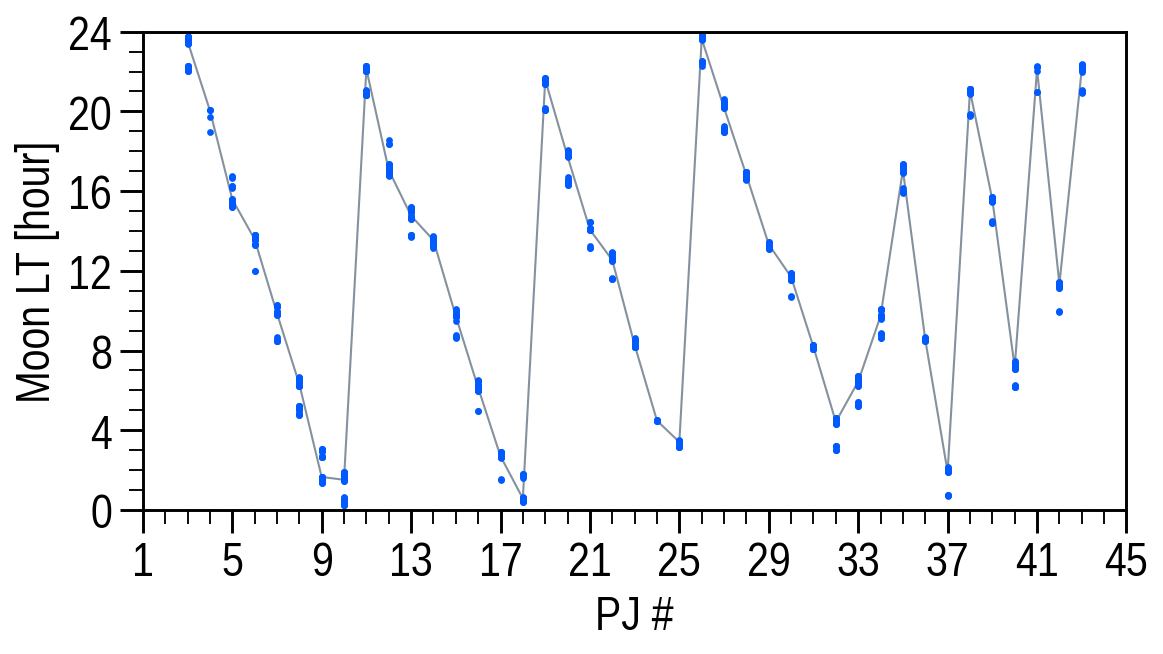

In [37]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8, 4.5), ticksize=1.5,
                dpi='M')
F.initialize()

F.set_xaxis(label='PJ #',
            min=1, max=45,
            ticks=np.arange(1, 45+1, 4),
            ticklabels=np.arange(1, 45+1, 4),
            minor_num=4)
F.set_yaxis(ax_idx=0, label='Moon LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24+1, 4),
            ticklabels=np.arange(0, 24+1, 4),
            minor_num=4)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon(moon_et[i], target_moon)
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax.scatter(pj*np.ones(lt_arr.size), lt_arr, s=5.0, color=UC.blue)

F.ax.plot(PJ_LIST, lt_med, color=UC.gray, linewidth=1.0, zorder=0.5)

In [38]:
pos_moon, _ = spice.spkpos(
    targ=target_moon, et=moon_et[0], ref='JUNO_JSS', abcorr='None', obs='JUPITER'
)

print(pos_moon/71492)
print(np.sqrt(pos_moon[0]**2+pos_moon[1]**2+pos_moon[2]**2)/71492)

LT = 24.0*np.arctan2(pos_moon[1], pos_moon[0])/(2*np.pi) + 12.0

[-4.12455526e+00  4.24288139e+00  3.81745782e-03]
5.917263990077149


In [39]:
def local_time_moon2(et: float, MOON: str, abcorr='none'):
    # Moon's position seen from Jupiter in IAU_JUPITER coordinate.
    pos_moon, _ = spice.spkpos(
        targ=MOON, et=et, ref='JUNO_JSS', abcorr=abcorr, obs='JUPITER'
    )

    # X axis pointing toward the Sun
    x_moon = pos_moon[0]*1E+3
    y_moon = pos_moon[1]*1E+3
    z_moon = pos_moon[2]*1E+3

    r_moon = np.sqrt(x_moon**2 + y_moon**2 + z_moon**2)
    theta_moon = np.arccos(z_moon/r_moon)
    phi_moon = np.arctan2(y_moon, x_moon)

    local_time = (24.0*phi_moon)/(2*np.pi) + 12.0   # [hour]

    return local_time

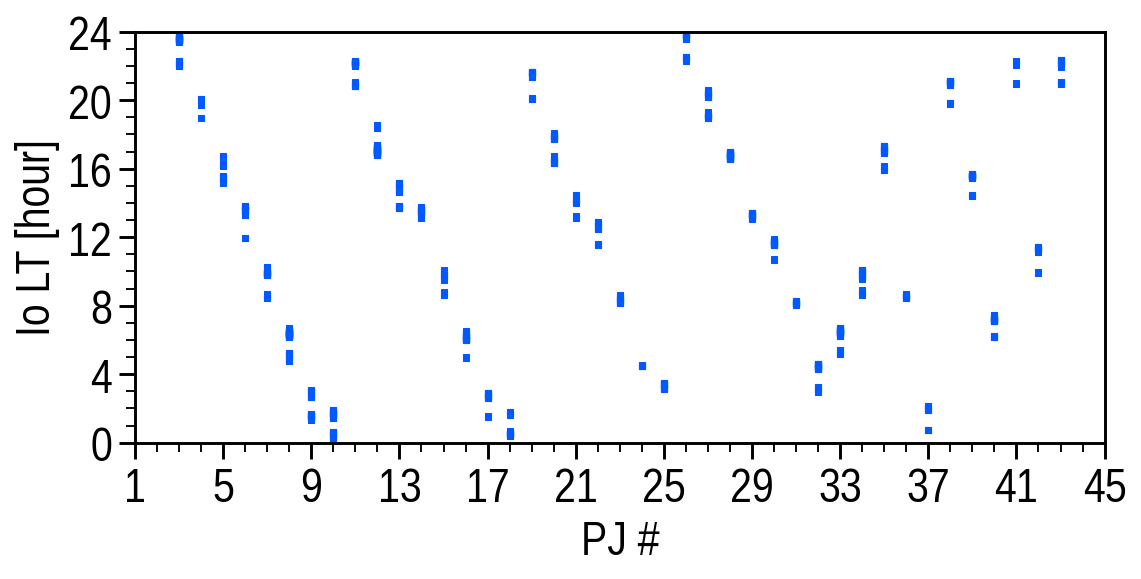

In [40]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8, 4),
                dpi='M')
F.initialize()

F.set_xaxis(label='PJ #',
            min=1, max=45,
            ticks=np.arange(1, 45+1, 4),
            ticklabels=np.arange(1, 45+1, 4),
            minor_num=4)
F.set_yaxis(ax_idx=0, label='Io LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24+1, 4),
            ticklabels=np.arange(0, 24+1, 4),
            minor_num=4)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax.scatter(pj*np.ones(lt_arr.size), lt_arr,
                 s=9.0, marker='s', color=UC.blue,
                 linewidth=0.5)

# F.ax.plot(PJ_LIST, lt_med, color=UC.blue, linewidth=2.0, zorder=0.5)

time format 0
time format 1


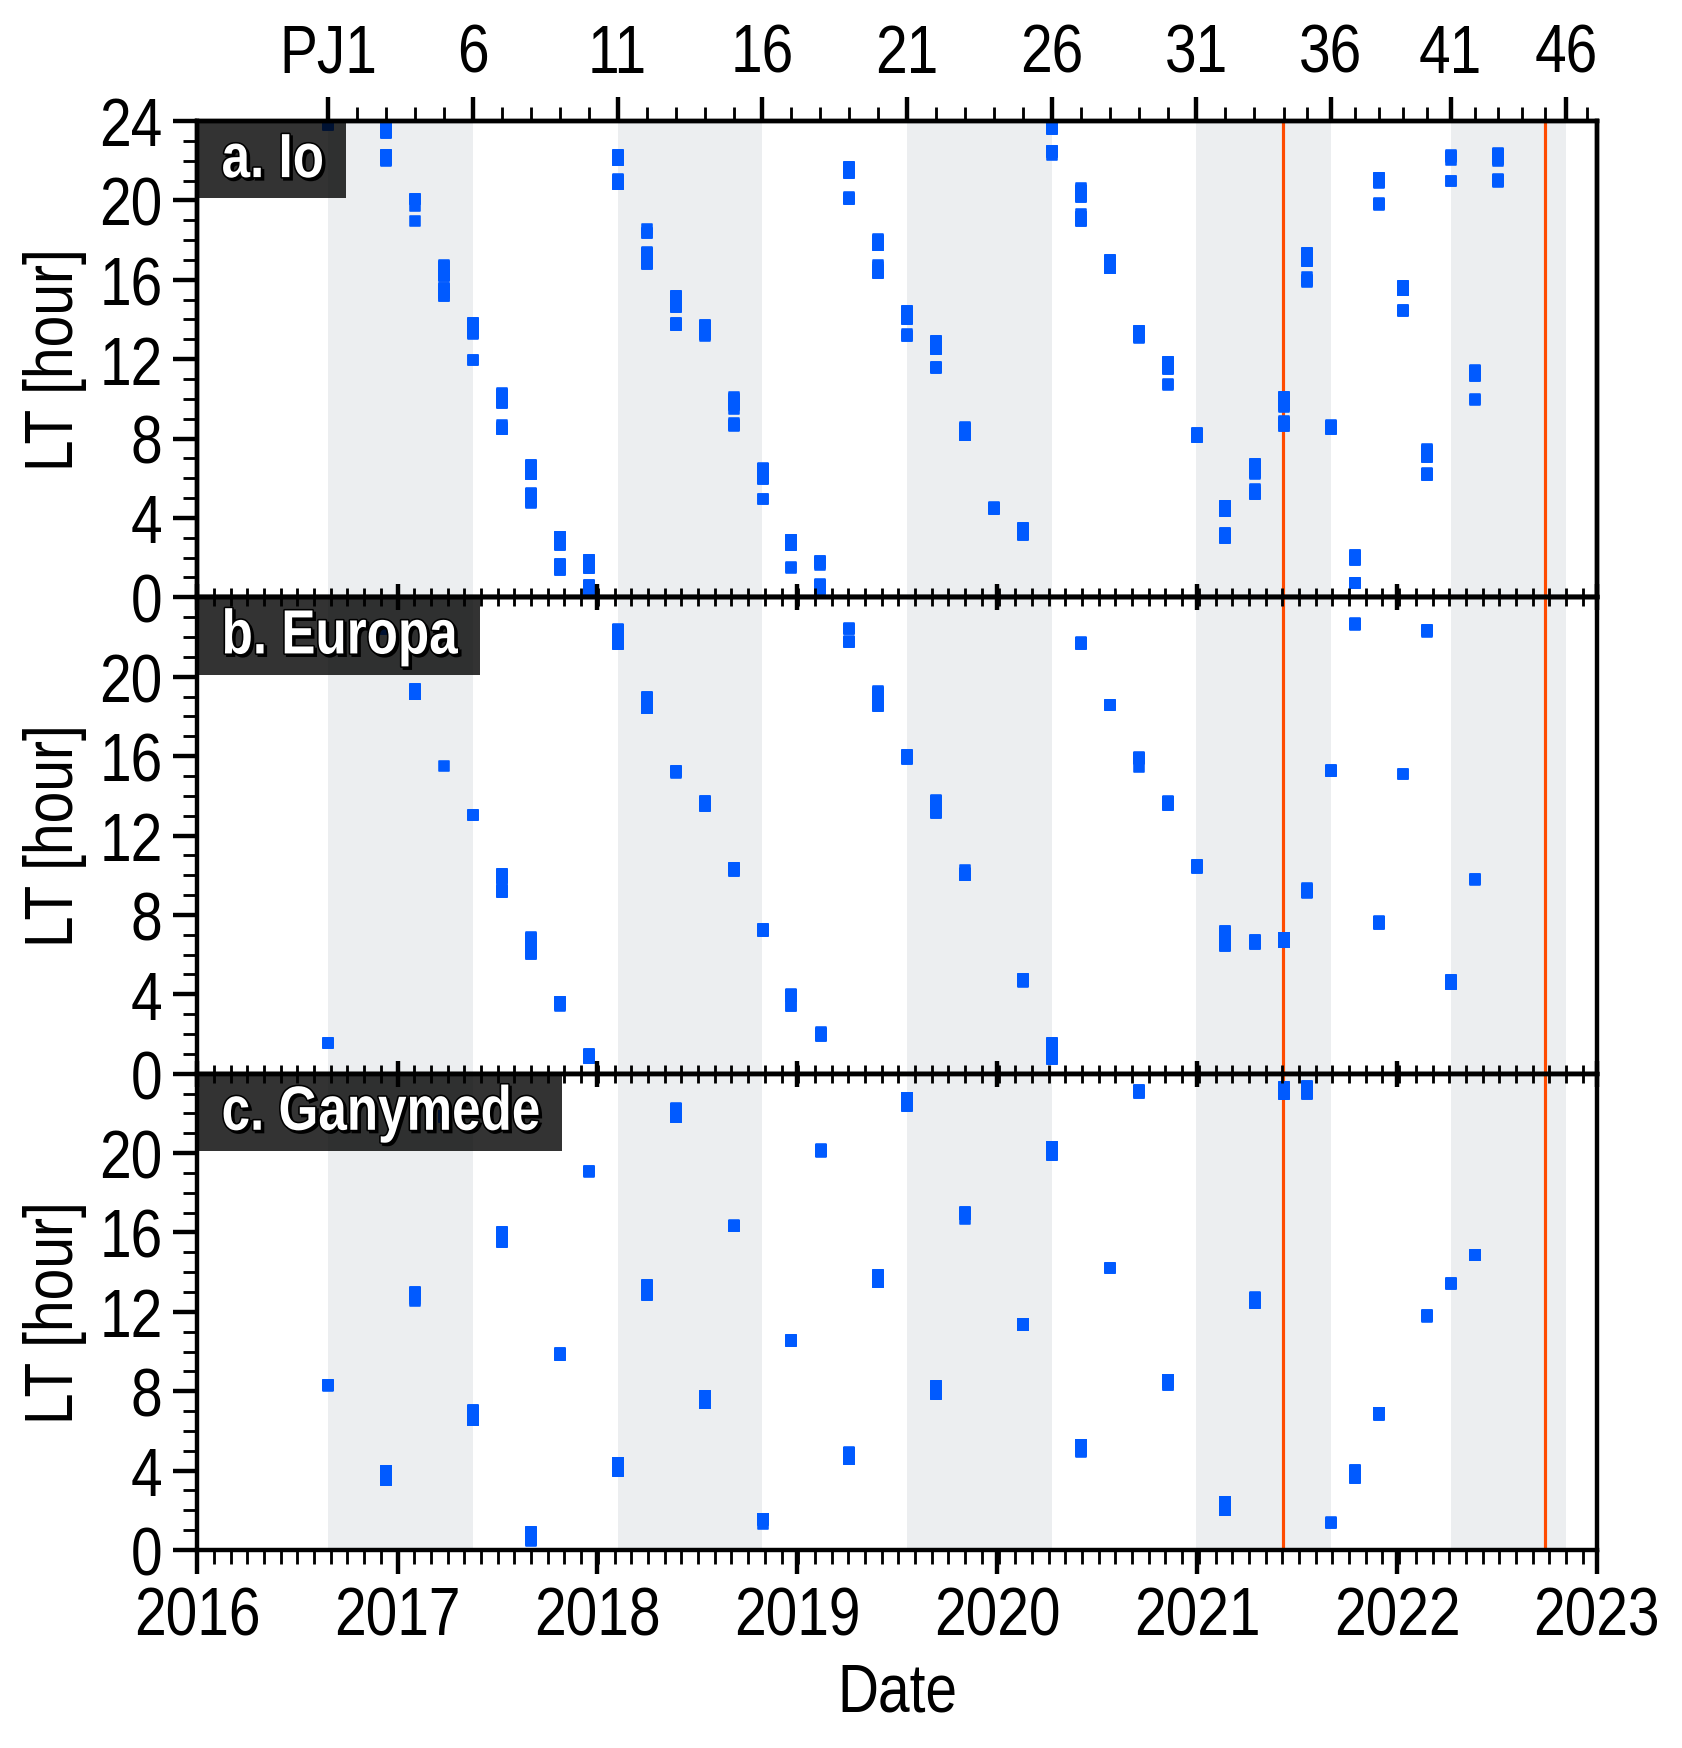

In [41]:
# %% 横軸をPJ番号でプロットする(4)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=3, figsize=(7.5, 7.5), dpi='L')
F.initialize()
F.panelname = [' a. Io ', ' b. Europa ', ' c. Ganymede ']

sxmin = '2016-01-01'
sxmax = '2023-01-01'
xmin = datetime.datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.datetime.strptime(sxmax, '%Y-%m-%d')
xticks = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2023-01-01', '%Y-%m-%d'),]
xticklabels = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
F.set_xaxis(label='Date',
            min=xmin, max=xmax,
            ticks=xticks,
            ticklabels=xticklabels,
            minor_num=12)
ticklabels = F.ax[2].get_xticklabels()
ticklabels[0].set_ha('center')

target_moon_list = ['Io', 'Europa', 'Ganymede']
for j in range(3):
    target_moon = target_moon_list[j]

    PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
    if target_moon == 'Io':
        Psyn = Psyn_io
    elif target_moon == 'Europa':
        Psyn = Psyn_eu
        PJ_LIST.pop(24-2)
        PJ_LIST.pop(43-3)
    elif target_moon == 'Ganymede':
        Psyn = Psyn_ga
        PJ_LIST.pop(24-2)
        PJ_LIST.pop(31-3)
        PJ_LIST.pop(39-4)
        PJ_LIST.pop(43-5)

    if j == 0:
        F.set_yaxis(ax_idx=j, label='LT [hour]',
                    min=0, max=24,
                    ticks=np.arange(0, 24+1, 4),
                    ticklabels=np.arange(0, 24+1, 4),
                    minor_num=4)
    else:
        F.set_yaxis(ax_idx=j, label='LT [hour]',
                    min=0, max=24,
                    ticks=np.arange(0, 24, 4),
                    ticklabels=np.arange(0, 24, 4),
                    minor_num=4)

    lt_med = np.zeros(len(PJ_LIST))
    k = 0
    for pj in PJ_LIST:
        wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
            [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
        )

        eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                       err_wlon_fp,
                                                                       lat_fp,
                                                                       err_lat_fp,
                                                                       hem_fp,
                                                                       moon_S3wlon,
                                                                       target_moon)

        # 衛星ローカルタイムをリード角の分だけ補正
        moon_et = np.zeros(et_fp.size)
        for i in range(et_fp.size):
            t0 = spice.et2datetime(et_fp[i])
            omg_syn = 360/Psyn  # [deg/sec]
            tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
            dt = datetime.timedelta(seconds=tau_A)
            moon_et[i] = spice.datetime2et(t0+dt)

        lt_arr = np.zeros(moon_et.size)
        d0 = spice.et2datetime(moon_et[0])
        d0_list = []
        for i in range(lt_arr.size):
            lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
            d0_list += [d0]
        lt_med[k] = np.median(lt_arr)
        k += 1

        F.ax[j].scatter(d0_list, lt_arr,
                        s=9.0, marker='s', color=UC.blue,
                        linewidth=0.5, zorder=2.0)


# u_ax = F.upper_ax()
# u_ax.set_title(r'Flux tube mass contents',
#               fontsize=F.fontsize, weight='bold')

PJax = F.ax[0].twiny()
# PJax.set_title(r'Flux tube mass contents',
#                fontsize=F.fontsize, weight='bold')
xticks = [datetime.datetime.strptime('2016-08-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-10-19', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-12-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-02-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-03-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-05-19 06:00', '%Y-%m-%d %H:%M'),
          datetime.datetime.strptime('2017-07-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-09-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-10-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-12-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-02-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-04-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-05-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-07-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-09-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-02-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-04-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-05-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-09-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-11-03', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-12-26', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-02-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-04-10', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-06-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-07-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-09-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-11-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-12-30', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-02-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-04-15', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-06-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-09-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-10-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-11-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-02-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-04-09', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-07-05', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-08-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-11-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-12-15', '%Y-%m-%d'),]
xticklabels = ['PJ1', '', '', '', '',
               '6', '', '', '', '',
               '11', '', '', '', '',
               '16', '', '', '', '',
               '21', '', '', '', '',
               '26', '', '', '', '',
               '31', '', '', '', '',
               '36', '', '', '', '',
               '41', '', '', '', '',
               '46', '',]
PJax.set_xlim(xmin, xmax)
PJax.set_xticks(xticks[::5])
PJax.set_xticklabels(xticklabels[::5])
PJax.xaxis.set_minor_locator(FixedLocator(mdates.date2num(xticks)))
PJax.tick_params('y', grid_zorder=-10)

# Shades in each 5 perijove
for i in range(3):
    F.ax[i].axvspan(xticks[0], xticks[5], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[10], xticks[15], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[20], xticks[25], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[30], xticks[35], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[40], xticks[45], fc=UC.gray, ec=None, alpha=0.15)

# Satellite flyby
for i in range(3):
    F.ax[i].axvline(x=datetime.datetime.strptime('2021-06-07', '%Y-%m-%d'),
                    color=UC.red, linewidth=1.0, zorder=1.0)
    F.ax[i].axvline(x=datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
                    color=UC.red, linewidth=1.0, zorder=1.0)
    F.ax[i].axvline(x=datetime.datetime.strptime('2023-12-30', '%Y-%m-%d'),
                    color=UC.red, linewidth=1.0, zorder=1.0)

time format 0
time format 1


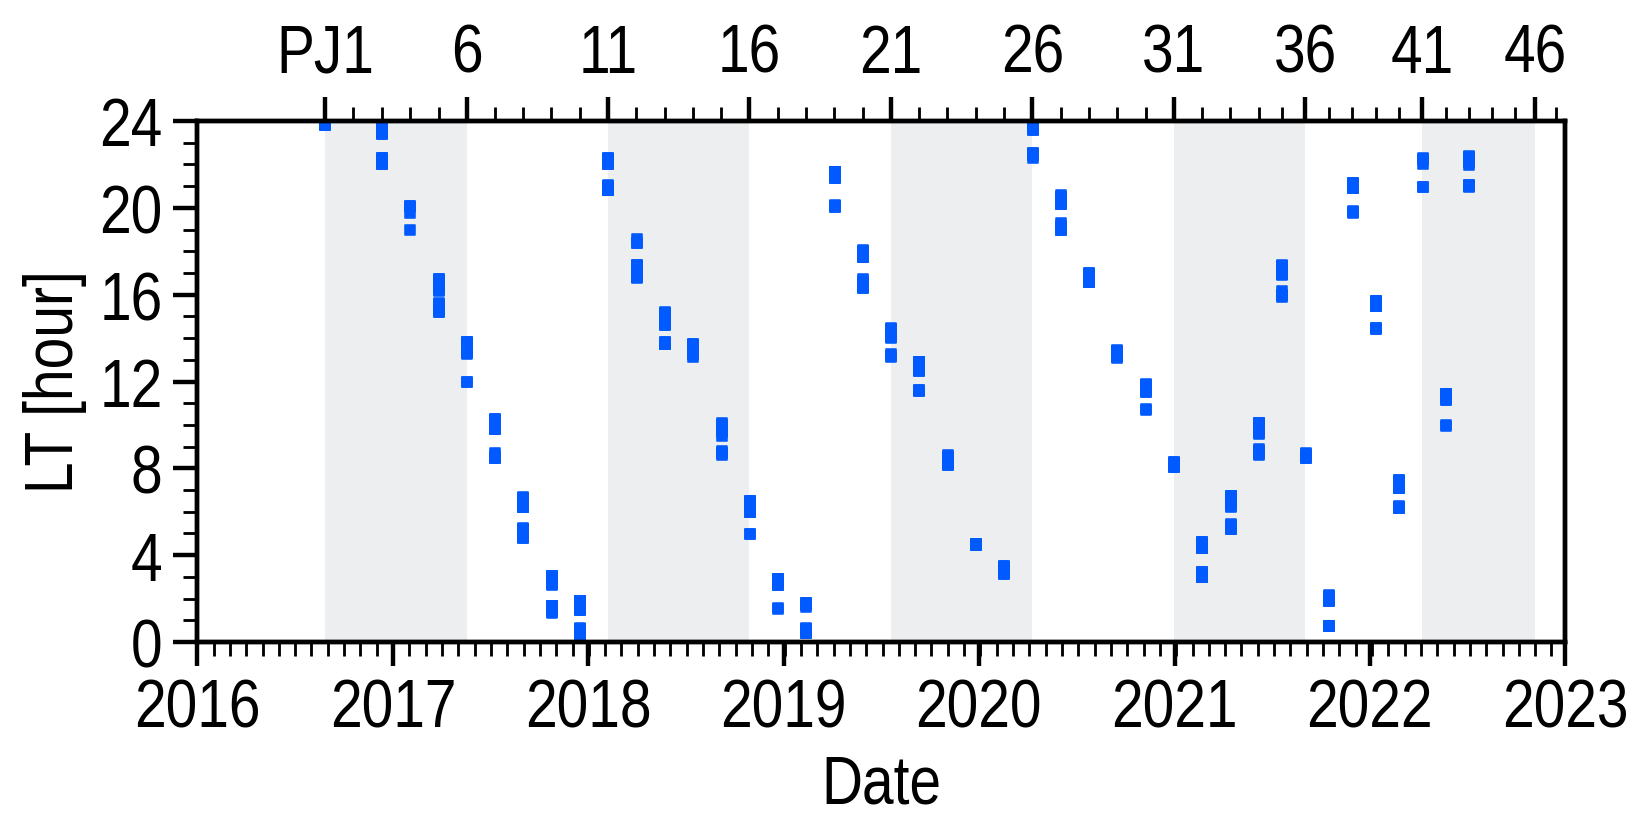

In [42]:
# %% 横軸をPJ番号でプロットする(5)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7.5, 3.5), dpi='L')
F.initialize()
F.panelname = [' a. Io ', ' b. Europa ', ' c. Ganymede ']

sxmin = '2016-01-01'
sxmax = '2023-01-01'
xmin = datetime.datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.datetime.strptime(sxmax, '%Y-%m-%d')
xticks = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2023-01-01', '%Y-%m-%d'),]
xticklabels = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
F.set_xaxis(label='Date',
            min=xmin, max=xmax,
            ticks=xticks,
            ticklabels=xticklabels,
            minor_num=12)
ticklabels = F.ax.get_xticklabels()
ticklabels[0].set_ha('center')

target_moon_list = ['Io', 'Europa', 'Ganymede']

j = 0
target_moon = target_moon_list[j]

PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
if target_moon == 'Io':
    Psyn = Psyn_io
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(43-3)
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(31-3)
    PJ_LIST.pop(39-4)
    PJ_LIST.pop(43-5)

if j == 0:
    F.set_yaxis(ax_idx=j, label='LT [hour]',
                min=0, max=24,
                ticks=np.arange(0, 24+1, 4),
                ticklabels=np.arange(0, 24+1, 4),
                minor_num=4)
else:
    F.set_yaxis(ax_idx=j, label='LT [hour]',
                min=0, max=24,
                ticks=np.arange(0, 24, 4),
                ticklabels=np.arange(0, 24, 4),
                minor_num=4)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    d0 = spice.et2datetime(moon_et[0])
    d0_list = []
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
        d0_list += [d0]
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax.scatter(d0_list, lt_arr,
                 s=9.0, marker='s', color=UC.blue,
                 linewidth=0.5, zorder=2.0)


# u_ax = F.upper_ax()
# u_ax.set_title(r'Flux tube mass contents',
#               fontsize=F.fontsize, weight='bold')

PJax = F.ax.twiny()
# PJax.set_title(r'Flux tube mass contents',
#                fontsize=F.fontsize, weight='bold')
xticks = [datetime.datetime.strptime('2016-08-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-10-19', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-12-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-02-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-03-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-05-19 06:00', '%Y-%m-%d %H:%M'),
          datetime.datetime.strptime('2017-07-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-09-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-10-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-12-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-02-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-04-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-05-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-07-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-09-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-02-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-04-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-05-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-09-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-11-03', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-12-26', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-02-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-04-10', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-06-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-07-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-09-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-11-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-12-30', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-02-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-04-15', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-06-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-09-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-10-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-11-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-02-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-04-09', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-07-05', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-08-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-11-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-12-15', '%Y-%m-%d'),]
xticklabels = ['PJ1', '', '', '', '',
               '6', '', '', '', '',
               '11', '', '', '', '',
               '16', '', '', '', '',
               '21', '', '', '', '',
               '26', '', '', '', '',
               '31', '', '', '', '',
               '36', '', '', '', '',
               '41', '', '', '', '',
               '46', '',]
PJax.set_xlim(xmin, xmax)
PJax.set_xticks(xticks[::5])
PJax.set_xticklabels(xticklabels[::5])
PJax.xaxis.set_minor_locator(FixedLocator(mdates.date2num(xticks)))
PJax.tick_params('y', grid_zorder=-10)

# Shades in each 5 perijove
F.ax.axvspan(xticks[0], xticks[5], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[10], xticks[15], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[20], xticks[25], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[30], xticks[35], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[40], xticks[45], fc=UC.gray, ec=None, alpha=0.15)

time format 0
time format 1


/tmp/ipykernel_17675/4173098276.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('turbo')


Min chi2: 15.452087753635354 at (array([49]), array([1]), array([19]))
Scale height [RJ]: 0.9826407927842512
Min chi2: 2.6088610124844256 at (array([32]), array([0]), array([25]))
Scale height [RJ]: 1.2653672042731248
Min chi2: 22.969460818710168 at (array([10]), array([1]), array([59]))
Scale height [RJ]: 4.331674461032781
Min chi2: 42.70498995881257 at (array([10]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 22.575067704039007 at (array([11]), array([2]), array([47]))
Scale height [RJ]: 2.611941977866135
Min chi2: 3.4970256464103446 at (array([20]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 20.117852550948268 at (array([21]), array([2]), array([50]))
Scale height [RJ]: 2.9303845179925307
Min chi2: 15.020422147391905 at (array([24]), array([0]), array([36]))
Scale height [RJ]: 1.8871226613078333
Min chi2: 2.2581858325888593 at (array([17]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 2.914028721294

Min chi2: 10.325850479499568 at (array([16]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 27.397000475928817 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 7.637311558008639 at (array([10]), array([2]), array([58]))
Scale height [RJ]: 3.9897783588963396
Min chi2: 12.921809257663778 at (array([35]), array([0]), array([8]))
Scale height [RJ]: 0.7363033936473369
Min chi2: 3.6779096384214753 at (array([20]), array([0]), array([49]))
Scale height [RJ]: 3.0891513440140144
Min chi2: 50.04337474267848 at (array([16]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 12.514740556737937 at (array([49]), array([2]), array([17]))
Scale height [RJ]: 0.881152309838059
Min chi2: 14.244875423520739 at (array([17]), array([2]), array([31]))
Scale height [RJ]: 1.4324007097082254
Min chi2: 10.03435952918972 at (array([17]), array([2]), array([52]))
Scale height [RJ]: 3.1647239574558332
Min chi2: 1.7360143038546

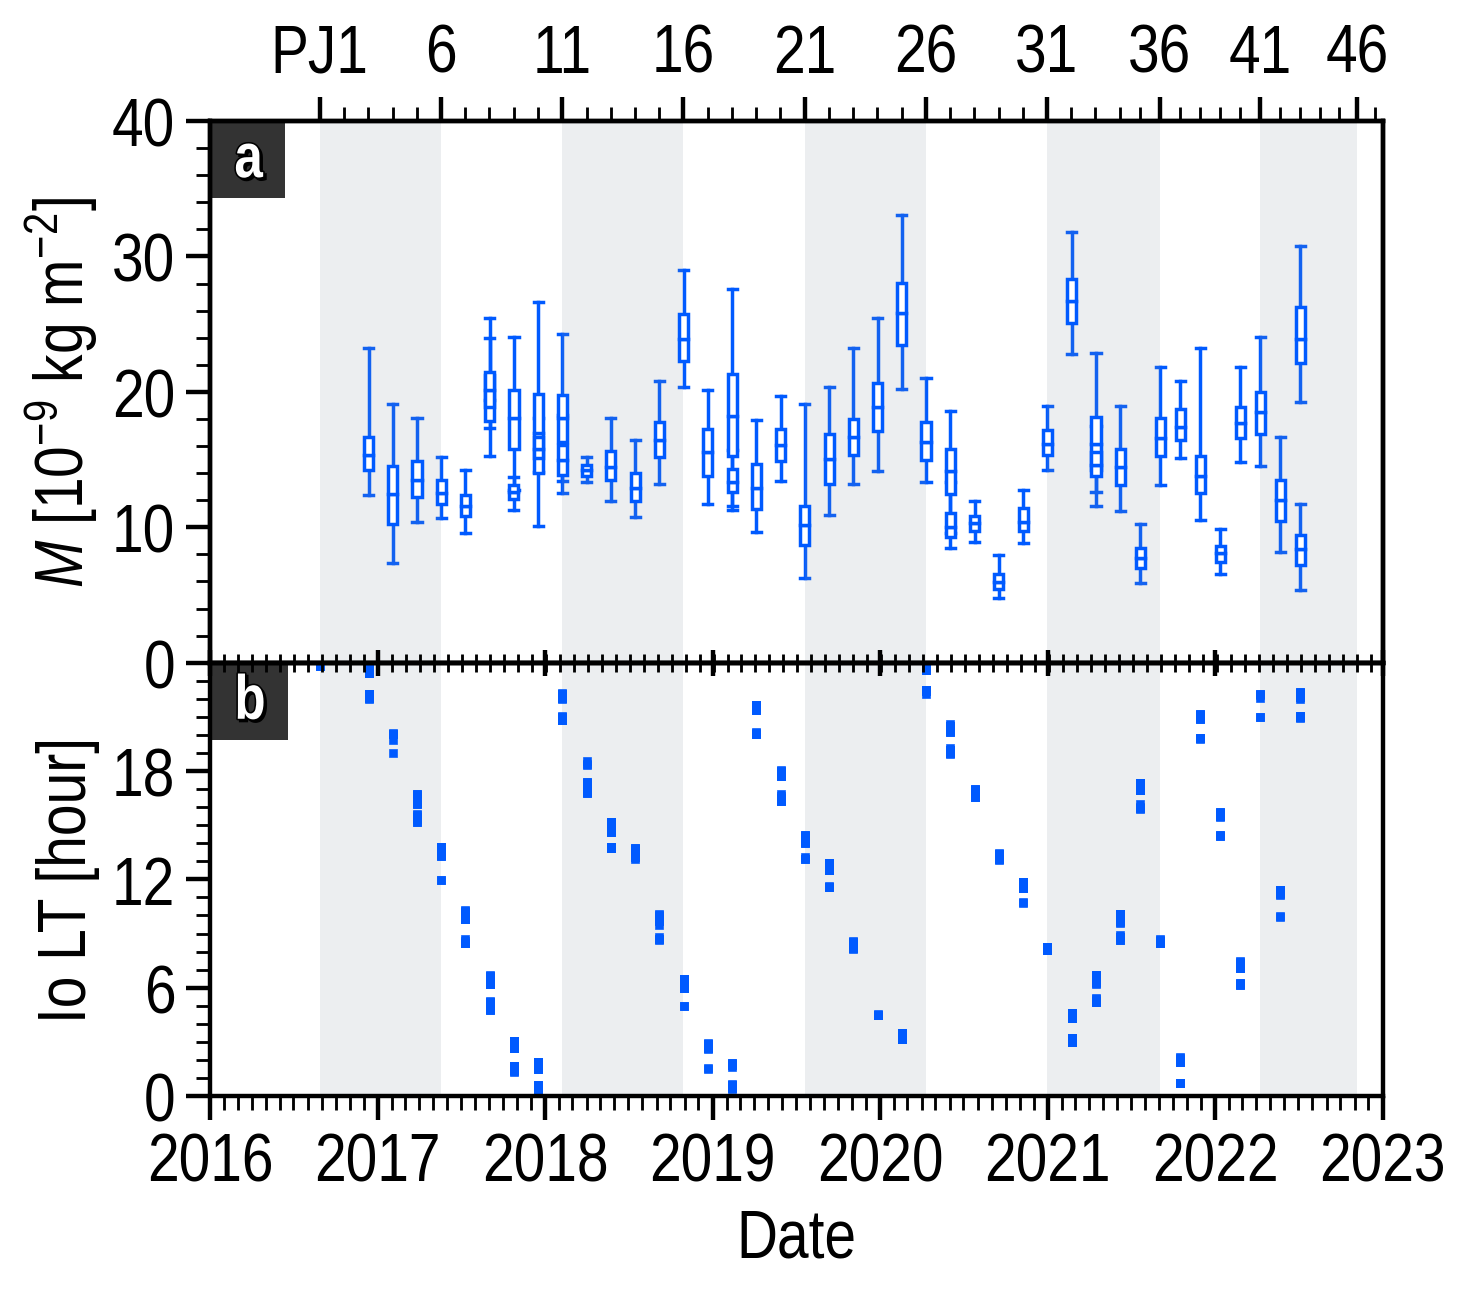

In [43]:
# %% 横軸をPJ番号でプロットする(6)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=2, figsize=(6.5, 5.5), height_ratios=[1, 0.8], dpi='L')
F.initialize()
# F.panelname = [' a. Io ', ' b. Europa ', ' c. Ganymede ']

sxmin = '2016-01-01'
sxmax = '2023-01-01'
xmin = datetime.datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.datetime.strptime(sxmax, '%Y-%m-%d')
xticks = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2023-01-01', '%Y-%m-%d'),]
xticklabels = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
F.set_xaxis(label='Date',
            min=xmin, max=xmax,
            ticks=xticks,
            ticklabels=xticklabels,
            minor_num=12)
F.ax[1].minorticks_off()
F.ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ticklabels = F.ax[1].get_xticklabels()
ticklabels[0].set_ha('center')

# target_moon_list = ['Io', 'Europa', 'Ganymede']

j = 0
target_moon = target_moon_list[j]

PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
if target_moon == 'Io':
    Psyn = Psyn_io
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(43-3)
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(31-3)
    PJ_LIST.pop(39-4)
    PJ_LIST.pop(43-5)

target_moon = target_moon_list[j]
if (exdate == '003/20250516') and (target_moon == 'Europa'):
    exnum = ['001', '002', '005', '006',
             '007', '010', '011',
             '012', '013', '014', '015', '016',
             '017', '018', '019', '020', '021',
             '022', '023', '024', '025', '026',
             '027', '028', '029', '030', '031',
             '032', '034', '035', '036',
             '037', '038',
             '039', '040', '041', '042'
             ]
    PJ_list = [3, 4, 8, 9,
               10, 13, 14,
               15, 16, 17, 18, 19,
               20, 21, 22, 23, 25,
               26, 27, 28, 29, 30,
               31, 32, 33, 34, 35,
               36, 38, 40, 41,
               7, 7,
               11, 11, 12, 12,
               ]
    Psyn = Psyn_eu
    ymax = 4.8
    ticks = np.arange(0, 4+1, 1)

elif (exdate == '003/20250516') and (target_moon == 'Io'):
    exnum = ['047', '048', '049', '050', '051',
             '052', '053', '054', '055', '056', '057',
             '058', '059',
             '062', '063', '064', '065', '066',
             '067', '068', '069', '070', '071',
             '072', '073', '074', '075', '076',
             '077', '078', '079', '080', '081',
             '083',
             '084', '085', '086', '088',
             '089', '090', '091', '092', '094',
             '095', '096', '097', '098',
             '114', '116',
             ]
    PJ_list = [3, 4, 5, 6, 7,
               8, 8, 9, 9, 10, 10,
               11, 11,
               13, 14, 15, 16, 17,
               18, 19, 20, 21, 22,
               23, 24, 25, 26, 27,
               27, 28, 29, 30, 31,
               32,
               33, 33, 34, 35,
               36, 37, 38, 39, 40,
               41, 42, 43, 43,
               18, 12,
               ]
    Psyn = Psyn_io
    ymax = 40
    ticks = np.arange(0, 40+1, 10)

elif (exdate == '003/20250516') and (target_moon == 'Ganymede'):
    exnum = ['100', '104', '105', '106', '107',
             '108', '109', '110', '111', '112',
             '113', '118', '119', '120', '121',
             '123', '124', '125', '126', '127',
             '128', '129', '131', '132', '134',
             '133', '136', '137', '138', '139',
             '140', '141', '142', '143',
             ]
    PJ_list = [3, 4, 5, 6, 7,
               8, 11, 12, 13, 14,
               15, 16, 17, 18, 19,
               20, 21, 22, 23, 25,
               26, 27, 29, 30, 32,
               33, 34, 34, 35, 37,
               38, 40, 41, 42,
               ]
    Psyn = Psyn_ga
    ymax = 0.24
    ticks = np.arange(0, 0.30, 0.10)

column_mass_1dN = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/col_massdens_1dN.txt')
column_mass_1dS = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/col_massdens_1dS.txt')
ftmc_mag_1dN = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/ftmc_mag_1dN.txt')
ftmc_mag_1dS = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/ftmc_mag_1dS.txt')
column_mass_1d = column_mass_1dN+column_mass_1dS
column_mass_3d = column_mass_1d.reshape(ni_num, Ai_num, Ti_num)
ftmc_mag_1d = ftmc_mag_1dN + ftmc_mag_1dS
ftmc_mag_3d = ftmc_mag_1d.reshape(ni_num, Ai_num, Ti_num)

F.set_yaxis(ax_idx=0,
            label='$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)

positions = np.arange(0, len(exnum)+1, 1)
colormap = plt.cm.get_cmap('turbo')
for i in range(len(exnum)):
    # %% Load the data
    exname = exdate+'_'+exnum[i]
    column_mass, chi2r, moon_et, _, moon_S3wlon, weight = data_load(
        exname)     # [kg m-2]
    column_mass *= 1E+9  # [10^-9 kg m-2]

    # Local time
    d0 = spice.et2datetime(moon_et[0])
    d0_list = []
    for ii in range(column_mass.size):
        d0_list += [d0]
    lt_arr = np.zeros(moon_et.size)
    for k in range(moon_et.size):
        lt_arr[k] = local_time_moon(moon_et[k], target_moon)

    lt_center = (lt_arr[0]+lt_arr[-1])/2

    q1, medians, q3 = weighted_percentile(data=column_mass,
                                          perc=[0.25, 0.5, 0.75],
                                          weights=weight)
    width = datetime.timedelta(seconds=60*60*24*20)
    weighted_boxplot2(F.ax[0], d0, q1, medians, q3,
                      np.min(column_mass),
                      np.max(column_mass), width=width,
                      ec=UC.blue, lw=1.1)


#
#
#
#
F.set_yaxis(ax_idx=1, label='Io LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24, 6),
            ticklabels=np.arange(0, 24, 6),
            minor_num=6)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    d0 = spice.et2datetime(moon_et[0])
    d0_list = []
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
        d0_list += [d0]
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax[1].scatter(d0_list, lt_arr,
                    s=5.0, marker='s', color=UC.blue,
                    linewidth=0.2, zorder=2.0)


# u_ax = F.upper_ax()
# u_ax.set_title(r'Flux tube mass contents',
#               fontsize=F.fontsize, weight='bold')

PJax = F.ax[0].twiny()
# PJax.set_title(r'Flux tube mass contents',
#                fontsize=F.fontsize, weight='bold')
xticks = [datetime.datetime.strptime('2016-08-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-10-19', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-12-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-02-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-03-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-05-19 06:00', '%Y-%m-%d %H:%M'),
          datetime.datetime.strptime('2017-07-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-09-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-10-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-12-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-02-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-04-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-05-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-07-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-09-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-02-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-04-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-05-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-09-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-11-03', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-12-26', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-02-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-04-10', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-06-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-07-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-09-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-11-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-12-30', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-02-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-04-15', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-06-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-09-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-10-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-11-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-02-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-04-09', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-07-05', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-08-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-11-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-12-15', '%Y-%m-%d'),]
xticklabels = ['PJ1', '', '', '', '',
               '6', '', '', '', '',
               '11', '', '', '', '',
               '16', '', '', '', '',
               '21', '', '', '', '',
               '26', '', '', '', '',
               '31', '', '', '', '',
               '36', '', '', '', '',
               '41', '', '', '', '',
               '46', '',]
PJax.set_xlim(xmin, xmax)
PJax.set_xticks(xticks[::5])
PJax.set_xticklabels(xticklabels[::5])
PJax.xaxis.set_minor_locator(FixedLocator(mdates.date2num(xticks)))
PJax.tick_params('y', grid_zorder=-10)

# Shades in each 5 perijove
for i in range(2):
    F.ax[i].axvspan(xticks[0], xticks[5], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[10], xticks[15], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[20], xticks[25], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[30], xticks[35], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[40], xticks[45], fc=UC.gray, ec=None, alpha=0.15)

F.fig.savefig('img/ftmc_lt_Io_r.pdf', bbox_inches='tight')
plt.show()

In [16]:
# %% フィッティング用の三角関数
def fit_func2(params, x):
    a, c, d = params
    return a * np.cos(2*np.pi*(x-c)/24.0) + d

In [17]:
x_arr = np.zeros(3)
y_arr = np.zeros(3)
x_err_arr = np.zeros(3)
medians_arr = np.zeros(len(exnum))
q05_arr = np.zeros(len(exnum))
q25_arr = np.zeros(len(exnum))
q75_arr = np.zeros(len(exnum))
q95_arr = np.zeros(len(exnum))
medians_x = np.zeros(len(exnum))
medians_x_err = np.zeros(len(exnum))
y_sigma_arr = np.zeros(len(exnum))
jj = 0
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, moon_S3wlon, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        lt_range = abs(lt_arr[0]-lt_arr[-1])

        q25, medians, q75 = weighted_percentile(data=column_mass,
                                                perc=[0.25, 0.5, 0.75],
                                                weights=weight)
        q05, medians, q95 = weighted_percentile(data=column_mass,
                                                perc=[0.05, 0.5, 0.95],
                                                weights=weight)

        if jj < len(exnum):
            x_arr = np.append(x_arr, lt_center*np.ones(column_mass.size))
            y_arr = np.append(y_arr, column_mass)
            x_err_arr = np.append(x_err_arr, lt_range *
                                  np.ones(column_mass.size))

            medians_arr[jj] = medians
            q05_arr[jj] = q05
            q25_arr[jj] = q25
            q75_arr[jj] = q75
            q95_arr[jj] = q95
            medians_x[jj] = lt_center
            medians_x_err[jj] = lt_range
            y_sigma_arr[jj] = np.std(column_mass)
            jj += 1

Min chi2: 15.452087753635354 at (array([49]), array([1]), array([19]))
Scale height [RJ]: 0.9826407927842512
Min chi2: 2.6088610124844256 at (array([32]), array([0]), array([25]))
Scale height [RJ]: 1.2653672042731248
Min chi2: 22.969460818710168 at (array([10]), array([1]), array([59]))
Scale height [RJ]: 4.331674461032781
Min chi2: 42.70498995881257 at (array([10]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 22.575067704039007 at (array([11]), array([2]), array([47]))
Scale height [RJ]: 2.611941977866135
Min chi2: 3.4970256464103446 at (array([20]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 20.117852550948268 at (array([21]), array([2]), array([50]))
Scale height [RJ]: 2.9303845179925307
Min chi2: 15.020422147391905 at (array([24]), array([0]), array([36]))
Scale height [RJ]: 1.8871226613078333
Min chi2: 2.2581858325888593 at (array([17]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 2.914028721294

Min chi2: 17.705224100618107 at (array([45]), array([2]), array([0]))
Scale height [RJ]: 0.5511684557979226
Min chi2: 57.05920019815454 at (array([20]), array([0]), array([35]))
Scale height [RJ]: 1.818194239014057
Min chi2: 8.01278182877919 at (array([32]), array([0]), array([4]))
Scale height [RJ]: 0.6630178141918078
Min chi2: 7.818825171327096 at (array([33]), array([1]), array([19]))
Scale height [RJ]: 0.9826407927842512
Min chi2: 32.92472779799009 at (array([14]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 11.433035346331463 at (array([24]), array([1]), array([59]))
Scale height [RJ]: 4.331674461032781
Min chi2: 10.325850479499568 at (array([16]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 27.397000475928817 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 7.637311558008639 at (array([10]), array([2]), array([58]))
Scale height [RJ]: 3.9897783588963396
Min chi2: 12.921809257663778 a

Min chi2: 15.452087753635354 at (array([49]), array([1]), array([19]))
Scale height [RJ]: 0.9826407927842512
Min chi2: 2.6088610124844256 at (array([32]), array([0]), array([25]))
Scale height [RJ]: 1.2653672042731248
Min chi2: 22.969460818710168 at (array([10]), array([1]), array([59]))
Scale height [RJ]: 4.331674461032781
Min chi2: 42.70498995881257 at (array([10]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 22.575067704039007 at (array([11]), array([2]), array([47]))
Scale height [RJ]: 2.611941977866135
Min chi2: 3.4970256464103446 at (array([20]), array([0]), array([58]))
Scale height [RJ]: 4.3705832132269355
Min chi2: 20.117852550948268 at (array([21]), array([2]), array([50]))
Scale height [RJ]: 2.9303845179925307
Min chi2: 15.020422147391905 at (array([24]), array([0]), array([36]))
Scale height [RJ]: 1.8871226613078333
Min chi2: 2.2581858325888593 at (array([17]), array([0]), array([59]))
Scale height [RJ]: 4.543098502123853
Min chi2: 2.914028721294

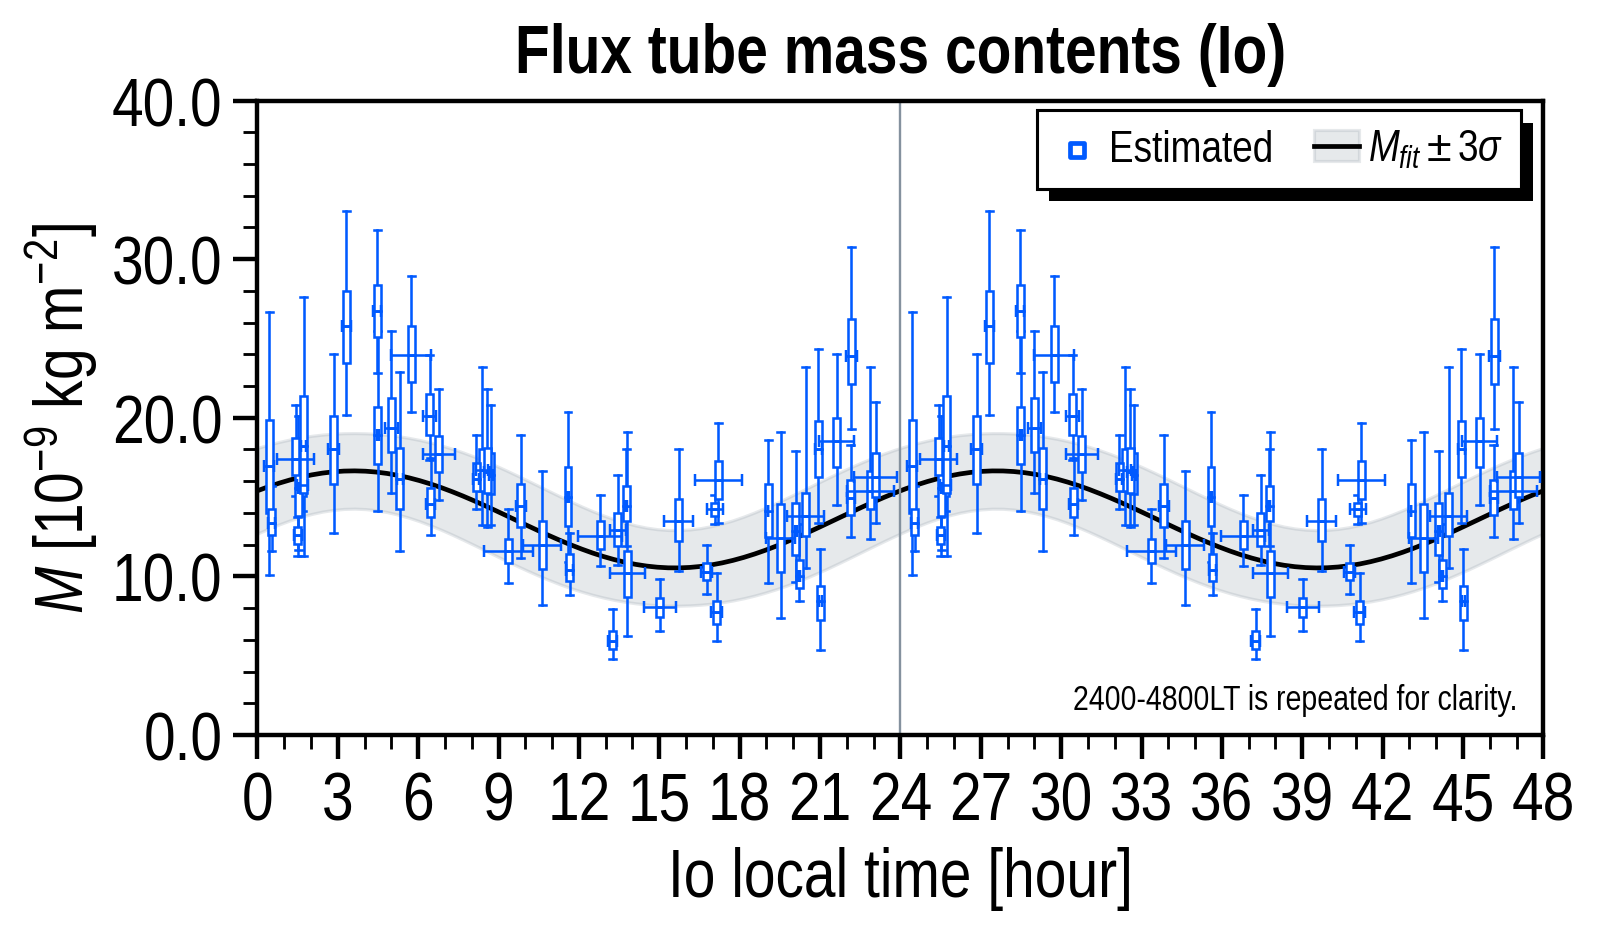

In [28]:
from matplotlib.ticker import FormatStrFormatter
from scipy.odr import ODR, Model, RealData
from Leadangle_fit_JunoUVS import spice_moonS3

# %% 横軸LT(48時間) 散布図 ベストフィット付き (これが一番大事)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' local time [hour]',
            min=0, max=48,
            ticks=np.arange(0, 48+1, 3),
            ticklabels=np.arange(0, 48+1, 3),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)
F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

x_arr = medians_x
y_arr = medians_arr
x_err_arr = medians_x_err/2
y_err_arr = y_sigma_arr

sort = np.argsort(x_arr)[::-1]
x_arr, y_arr, x_err_arr, y_err_arr = x_arr[sort], y_arr[sort], x_err_arr[sort], y_err_arr[sort]

# ODR 用データとモデルの設定
data = RealData(x_arr, y_arr, sx=x_err_arr, sy=y_err_arr)
model = Model(fit_func2)

# ODR 実行
odr_instance = ODR(data, model, beta0=[1.0, 1.0, 1.0])
output = odr_instance.run()

# フィッティング結果
popt = output.beta
perr = output.sd_beta
# perr = np.sqrt(np.diag(output.cov_beta)) # maybe wrong

# ベストフィット
nstd = 3  # 95% 信頼区間
x_fit = np.linspace(0.0, 48.0, 120)
y_fit = fit_func2(popt, x_fit)
lmean, = F.ax.plot(x_fit, y_fit, zorder=0.1, label='1', color='k')

# 予測区間の計算
y_fit_err2 = ((np.pi*popt[0]/12.0)*np.sin(np.pi*(x_fit-popt[1])/12.0)**2)*(
    perr[1]**2) + (np.cos(np.pi*(x_fit-popt[1])/12.0)*perr[0])**2 + perr[2]**2
y_fit_err = np.sqrt(y_fit_err2)
y_fit_up = y_fit + nstd * y_fit_err
y_fit_dw = y_fit - nstd * y_fit_err
lsigma = F.ax.fill_between(x_fit, y_fit_up, y_fit_dw,
                           color=UC.gray, alpha=0.2,
                           label='2',
                           zorder=0.01)

jj = 0
median_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        lt_range = abs(lt_arr[0]-lt_arr[-1])

        q1, medians, q3 = weighted_percentile(data=column_mass,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 0.26
        weighted_boxplot2(F.ax, lt_center, q1, medians, q3,
                          np.min(column_mass),
                          np.max(column_mass), width=width,
                          ec=UC.blue, lw=0.81)

        if abs(PJ_list[i]-round(PJ_list[i])) < 0.1:
            half_width = 0.41
            F.ax.errorbar(lt_center, medians,
                          xerr=np.array([[abs(lt_arr[0]+(24.0*ii)-lt_center)],
                                         [abs(lt_arr[-1]+(24.0*ii)-lt_center)]]),
                          color=UC.blue, linewidth=0.81, elinewidth=0.81,
                          capsize=5.0*half_width,
                          capthick=0.79,
                          zorder=5)

        if jj < len(exnum):
            jj += 1

        median_arr[i] = medians

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='3', zorder=4)

# LT=24.0
F.ax.axvline(x=24.0, color=UC.gray, linewidth=0.75)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '2400-4800LT is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

legend = F.legend(ax_idx=0,
                  handles=[sc, (lsigma, lmean)],
                  labels=['Estimated', r'$M_{fit} \pm 3\sigma$'],
                  bbox_to_anchor=(1.0, 1.02),
                  ncol=3, markerscale=3,
                  fontsize_scale=0.65, textcolor=True, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

F.ax.set_title(r'Flux tube mass contents ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')

F.fig.savefig('img/ftmc_lt_Io_48_r.pdf', bbox_inches='tight')
plt.show()